In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def print_shapes(*data):
    for d in data:
        print(d.shape)

In [3]:
def print_min_max(*data):
    for d in data:
        print(f'Min: {d.min()} Max: {d.max()}')

In [4]:
def make_noise(data, noise_level=0.25):
    vectors = []
    for v in data:
        noise = np.abs(np.random.randn(len(v)) * noise_level)
        noised_v = v + noise
        normalized_v = noised_v - np.min(noised_v)
        max_value = np.max(normalized_v)
        if max_value == 0: normalized_v = np.zeros_like(normalized_v)
        else: normalized_v = normalized_v / max_value
        vectors.append(normalized_v)
    return np.array(vectors)

In [5]:
path = r"C:\Users\nacho\Desktop\myGithub\Deep Learning\datasets\digits"
path_train = path + r'\train.csv'
path_test = path + r'\test.csv'

In [6]:
train_data = np.array(pd.read_csv(path_train)).astype(np.float32)
test_data = np.array(pd.read_csv(path_test)).astype(np.float32)

In [7]:
Y_train = train_data[:,1:] / 255.0
Y_test = test_data / 255.0
X_train = make_noise(Y_train)
X_test = make_noise(Y_test)

In [8]:
print_shapes(X_train, X_test)

(42000, 784)
(28000, 784)


In [9]:
print_min_max(X_train, X_test)

Min: 0.0 Max: 1.0
Min: 0.0 Max: 1.0


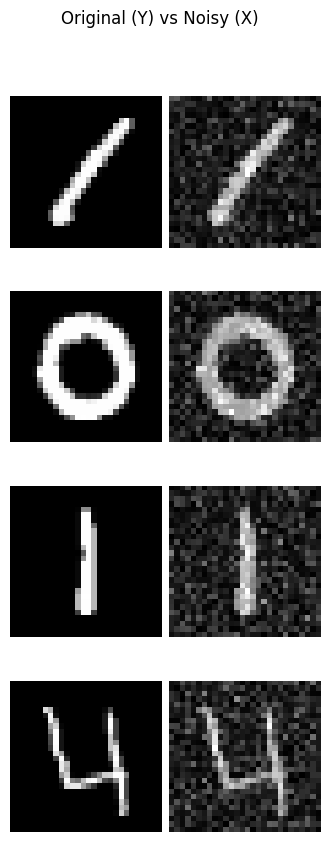

In [10]:
imgs = 4

fig, axes = plt.subplots(imgs, 2, figsize=(4, 10))
fig.suptitle("Original (Y) vs Noisy (X)", fontsize=12, y=0.95)

for i in range(imgs):
    axes[i, 0].imshow(Y_train[i].reshape(28, 28), cmap="gray", interpolation="nearest")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(X_train[i].reshape(28, 28), cmap="gray", interpolation="nearest")
    axes[i, 1].axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [11]:
def ReLU(x, derv=False):
    if derv: return np.where(x>0, 1, 0)
    return np.maximum(x, 0)

In [12]:
def sigmoid(x, derv=False):
    s = 1 / (1 + np.exp(-x))
    if derv: return s * (1 - s)
    return s

In [13]:
def BCE(y, y_pred, epsilon=1e-8, derv=False):
    if derv: return y_pred-y#-y/(y_pred+epsilon)+(1-y)/(1-y_pred+epsilon)
    return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

In [14]:
n_INPUTS = X_train.shape[1]
n_hidden0 = 128

latent = 64

n_hidden1 = 128
n_OUTPUTS = Y_train.shape[1]

In [15]:
# Encoder
encoder_W0 = np.random.randn(n_INPUTS, n_hidden0) * np.sqrt(2/n_INPUTS)
encoder_b0 = np.zeros((1, n_hidden0))

encoder_W1 = np.random.randn(n_hidden0, latent) * np.sqrt(2/n_hidden0)
encoder_b1 = np.zeros((1, latent))

# Decoder
decoder_W0 = np.random.randn(latent, n_hidden1) * np.sqrt(2/latent)
decoder_b0 = np.zeros((1, n_hidden1))

decoder_W1 = np.random.randn(n_hidden1, n_OUTPUTS) * np.sqrt(2/n_hidden1)
decoder_b1 = np.zeros((1, n_OUTPUTS))

In [16]:
def forward_encoder(X):
    global encoder_z0, encoder_a0, encoder_z1, encoder_a1
    
    encoder_z0 = X @ encoder_W0 + encoder_b0
    encoder_a0 = ReLU(encoder_z0)

    encoder_z1 = encoder_a0 @ encoder_W1 + encoder_b1
    encoder_a1 = ReLU(encoder_z1)

    return encoder_a1

In [17]:
def forward_decoder(X):
    global decoder_z0, decoder_a0, decoder_z1, decoder_a1
    
    decoder_z0 = X @ decoder_W0 + decoder_b0
    decoder_a0 = ReLU(decoder_z0)

    decoder_z1 = decoder_a0 @ decoder_W1 + decoder_b1
    decoder_a1 = sigmoid(decoder_z1)

    return decoder_a1

In [18]:
def forward_autoencoder(X):
    return forward_decoder(forward_encoder(X))

In [19]:
def update_encoder(dW0, db0, dW1, db1, lr):
    global encoder_W0, encoder_W1, encoder_b0, encoder_b1

    encoder_W0 -= lr * dW0
    encoder_b0 -= lr * db0

    encoder_W1 -= lr * dW1
    encoder_b1 -= lr * db1

In [20]:
def update_decoder(dW0, db0, dW1, db1, lr):
    global decoder_W0, decoder_W1, decoder_b0, decoder_b1

    decoder_W0 -= lr * dW0
    decoder_b0 -= lr * db0

    decoder_W1 -= lr * dW1
    decoder_b1 -= lr * db1

In [21]:
def backward_decoder(x=None, y=None, outp=None, deltas=None, learn=True, lr=0.01):
    if y is not None:
        dL = BCE(y, outp, derv=True)
    elif deltas is not None:
        dL = deltas
    else: raise ValueError('There is no (y) or (deltas).')
    # dL *= sigmoid(decoder_z1, derv=True)
    m = dL.shape[1]

    dW1 = decoder_a0.T @ dL / m
    db1 = dL.sum(axis=0, keepdims=True) / m

    da0 = dL @ decoder_W1.T
    dz0 = da0 * ReLU(decoder_z0, derv=True)

    dW0 = x.T @ dz0 / m
    db0 = dz0.sum(axis=0, keepdims=True) / m

    deltas = dz0 @ decoder_W0.T

    if learn:
        update_decoder(dW0, db0, dW1, db1, lr)
    
    return deltas, dW0, db0, dW1, db1

In [22]:
def backward_encoder(x=None, y=None, outp=None, deltas=None, learn=True, lr=0.01):
    if y is not None:
        dL = BCE(y, outp, derv=True)
    elif deltas is not None:
        dL = deltas
    else: raise ValueError('There is no (y) or (deltas).')
    dL *= ReLU(encoder_z1, derv=True)
    m = dL.shape[1]

    dW1 = encoder_a0.T @ dL / m
    db1 = dL.sum(axis=0, keepdims=True) / m

    da0 = dL @ encoder_W1.T
    dz0 = da0 * ReLU(encoder_z0, derv=True)

    dW0 = x.T @ dz0 / m
    db0 = dz0.sum(axis=0, keepdims=True) / m

    deltas = dz0 @ encoder_W0.T

    if learn:
        update_encoder(dW0, db0, dW1, db1, lr)
    
    return deltas, dW0, db0, dW1, db1


In [23]:
def train(x, y, epochs=100, batch_size=32, lr=0.01, print_every=0.1):
    for epoch in range(1, epochs+1):
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        
        for batch in range(0, x.shape[0], batch_size):
            x_batch = x[batch:batch+batch_size]
            y_batch = y[batch:batch+batch_size]

            latent = forward_encoder(x_batch)
            predictions = forward_decoder(latent)
            
            deltas = backward_decoder(latent, y_batch, predictions, lr=lr)[0]
            backward_encoder(x_batch, deltas=deltas, lr=lr)

        if epoch % max(1, int(epochs*print_every)) == 0:
            print(f'Epochs: [{epoch}/{epochs}]> Loss: {BCE(y, forward_autoencoder(x)):.4f}')

In [24]:
train(
    x=X_train,
    y=Y_train,
    epochs=40,
    batch_size=128,
    lr=0.005,
    print_every=0.1
)

Epochs: [4/40]> Loss: 0.1765
Epochs: [8/40]> Loss: 0.1477
Epochs: [12/40]> Loss: 0.1302
Epochs: [16/40]> Loss: 0.1214
Epochs: [20/40]> Loss: 0.1151
Epochs: [24/40]> Loss: 0.1144
Epochs: [28/40]> Loss: 0.1090
Epochs: [32/40]> Loss: 0.1075
Epochs: [36/40]> Loss: 0.1030
Epochs: [40/40]> Loss: 0.1018


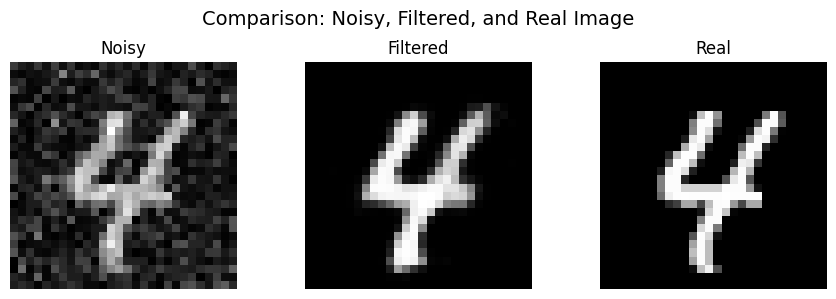

In [50]:
idx = np.random.randint(0, X_test.shape[0])
noisy_img = X_test[idx].reshape(28, 28)
real_img = Y_test[idx].reshape(28, 28)

filtered_img = forward_autoencoder(X_test[idx].reshape(1, -1)).reshape(28, 28)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
fig.suptitle("Comparison: Noisy, Filtered, and Real Image", fontsize=14)

axes[0].imshow(noisy_img, cmap="gray", interpolation="nearest")
axes[0].set_title("Noisy")
axes[0].axis("off")

axes[1].imshow(filtered_img, cmap="gray", interpolation="nearest")
axes[1].set_title("Filtered")
axes[1].axis("off")

axes[2].imshow(real_img, cmap="gray", interpolation="nearest")
axes[2].set_title("Real")
axes[2].axis("off")

plt.tight_layout()
plt.show()